In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
    # %cd '/content/drive/My Drive/Studies 2/Year 2/Final Project/project_git_repo/code'

In [3]:
# !pip install scanpy
# !pip install stlearn 
# !pip install matplotlib==3.4.3
# !pip install preprocessing

In [16]:
%load_ext autoreload
%autoreload 2
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [20, 10]
plt.rcParams["figure.autolayout"] = True

import os
from copy import deepcopy
import numpy as np
import pandas as pd
import stlearn as st

import torch
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split

module_path = os.path.abspath(os.path.join('../../FPST','code'))
if module_path not in sys.path:
    sys.path.append(module_path)

from load_data import Data
from train import engine
from image_data import *
from models import NMF
from plot import plot_train_vs_test, plot_genes_read_count, plot_true_vs_reconstructed_histogram

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# choose the device 
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(DEVICE)

cpu


In [8]:
# choose the dataset
dataset_name = '../data/Visium_Mouse_Olfactory_Bulb'

## Load data using stlearn

In [9]:
data = st.Read10X(dataset_name)
X = data.X.toarray()

/usr/local/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [10]:
BATCH_SIZE = 128
NUM_WORKERS = 1
dataset_name = 'Visium_Mouse_Olfactory_Bulb'
# train_array = pair_array[train_indices]
dataset = Data(batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, device = DEVICE)
dataset.set_dataloaders(X,data)

# NMF

In [81]:
params = {
    'learning_rate': 0.001,
    'optimizer': "RMSprop",
    'latent_dim': 20,
    'batch_size': BATCH_SIZE
}

In [90]:
number_of_spots = data.n_obs
number_of_genes = data.n_vars
nmf_model = NMF(number_of_genes, number_of_spots, params)

In [83]:
nmf_execute = engine(model = nmf_model,
                    model_name = 'NMF',
                    params = params,
                    epochs = 10,
                    dl_train = dataset.dl_train_top_genes,
                    dl_test = dataset.dl_test_top_genes,
                    device = DEVICE)

NMF(
  (embedding_genes): Embedding(32286, 20)
  (embedding_spots): Embedding(1186, 20)
)


In [84]:
nmf_train_losses, nmf_test_losses = nmf_execute.execute()

Train epoch 0/10: 100%|██████████| 750/750 [00:06<00:00, 119.34it/s]


Epoch #0 Train Loss: 5.312067032467683
Epoch #0 Test Loss: 5.052503277808914


Train epoch 1/10: 100%|██████████| 750/750 [00:08<00:00, 84.27it/s] 


Epoch #1 Train Loss: 5.04968639923423
Epoch #1 Test Loss: 4.842551364051871


Train epoch 2/10: 100%|██████████| 750/750 [00:09<00:00, 80.72it/s]


Epoch #2 Train Loss: 4.82589943684795
Epoch #2 Test Loss: 4.658382448958207


Train epoch 3/10: 100%|██████████| 750/750 [00:09<00:00, 77.67it/s]


Epoch #3 Train Loss: 4.627977763874824
Epoch #3 Test Loss: 4.4879576501068135


Train epoch 4/10: 100%|██████████| 750/750 [00:09<00:00, 77.35it/s]


Epoch #4 Train Loss: 4.442199834938202
Epoch #4 Test Loss: 4.3161461293497645


Train epoch 5/10: 100%|██████████| 750/750 [00:09<00:00, 78.35it/s]


Epoch #5 Train Loss: 4.252425532659856
Epoch #5 Test Loss: 4.125923437041998


Train epoch 6/10: 100%|██████████| 750/750 [00:09<00:00, 81.92it/s]


Epoch #6 Train Loss: 4.049041624623747
Epoch #6 Test Loss: 3.915594632457757


Train epoch 7/10: 100%|██████████| 750/750 [00:09<00:00, 82.83it/s]


Epoch #7 Train Loss: 3.8395063201094333
Epoch #7 Test Loss: 3.7030248854294694


Train epoch 8/10: 100%|██████████| 750/750 [00:09<00:00, 83.14it/s]


Epoch #8 Train Loss: 3.6401556127194947
Epoch #8 Test Loss: 3.506077952158813


Train epoch 9/10: 100%|██████████| 750/750 [00:08<00:00, 83.38it/s]


Epoch #9 Train Loss: 3.4609492304256553
Epoch #9 Test Loss: 3.332010634178115


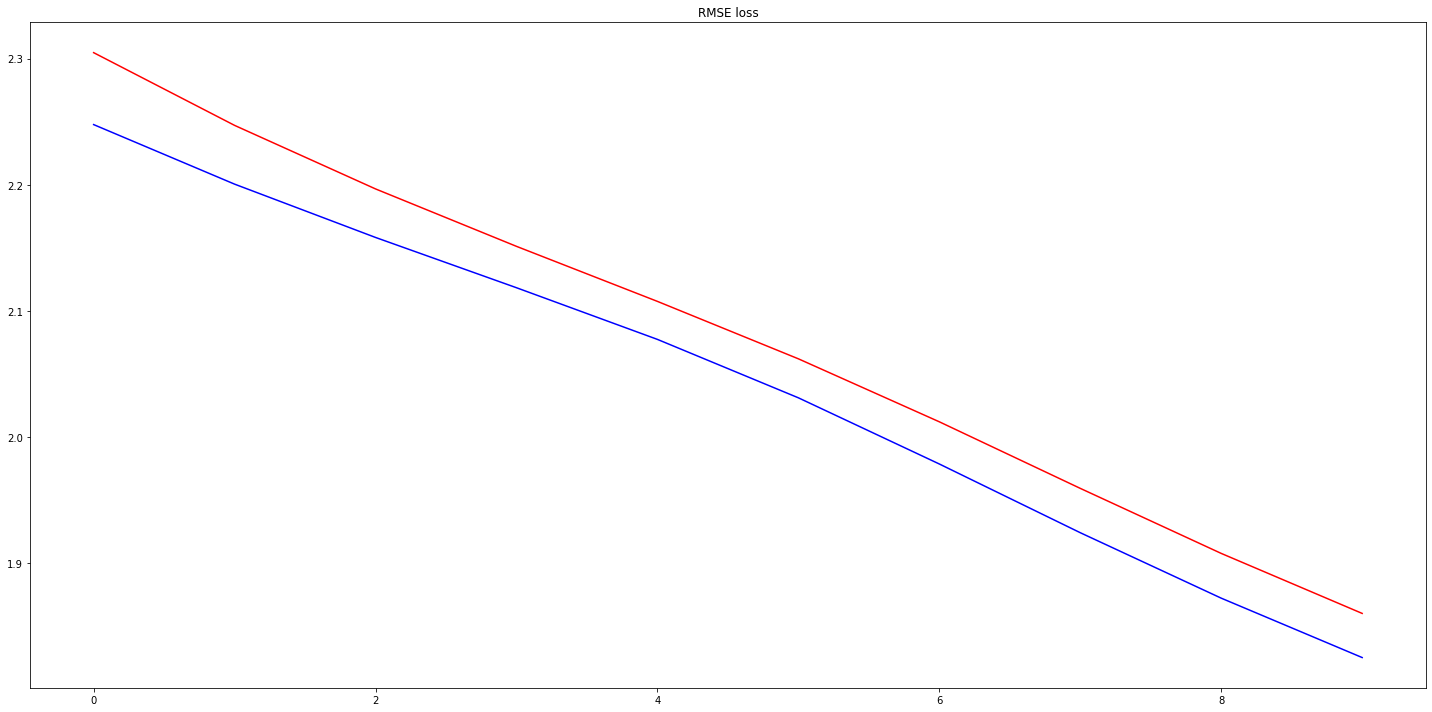

In [85]:
plot_train_vs_test(nmf_train_losses, nmf_test_losses, "RMSE loss")

In [86]:
df_expressions_preds, df_expressions_true, reconstructed_data = engine.create_reconstructed_data(nmf_model, dataset, data, DEVICE)

  (0, 18)	5.0
  (0, 26)	2.0
  (0, 73)	2.0
  (0, 78)	3.0
  (0, 55)	2.0
  (0, 72)	1.0
  (0, 80)	3.0
  (0, 40)	2.0
  (0, 62)	1.0
  (0, 84)	1.0
  (0, 0)	1.0
  (0, 47)	1.0
  (0, 35)	2.0
  (0, 54)	2.0
  (0, 25)	3.0
  (0, 31)	2.0
  (0, 81)	2.0
  (0, 52)	1.0
  (0, 3)	2.0
  (0, 71)	1.0
  (0, 70)	2.0
  (0, 65)	1.0
  (0, 24)	1.0
  (0, 27)	7.0
  (0, 51)	2.0
  :	:
  (1184, 56)	23.0
  (1184, 49)	9.0
  (1184, 36)	15.0
  (1184, 7)	24.0
  (1184, 64)	18.0
  (1184, 9)	17.0
  (1184, 68)	20.0
  (1184, 44)	13.0
  (1184, 5)	13.0
  (1184, 10)	25.0
  (1184, 22)	24.0
  (1184, 16)	32.0
  (1184, 23)	34.0
  (1184, 37)	19.0
  (1184, 85)	24.0
  (1184, 95)	196.0
  (1184, 96)	125.0
  (1184, 91)	891.0
  (1184, 92)	499.0
  (1184, 90)	524.0
  (1184, 93)	682.0
  (1184, 97)	42.0
  (1184, 98)	260.0
  (1184, 99)	36.0
  (1184, 94)	295.0 [[0.88323247 0.78439069 0.73230612 ... 0.86079973 3.01947522 0.88127697]
 [3.20230937 3.45988107 3.97604895 ... 3.80239487 5.27382565 3.43551993]
 [3.02969956 3.03643417 3.55891585 ... 3.02269

/usr/local/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


## Cluster reconstructed data

Normalization step is finished in adata.X
PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']
Applying Kmeans clustering ...
Kmeans clustering is done! The labels are stored in adata.obs["kmeans"]


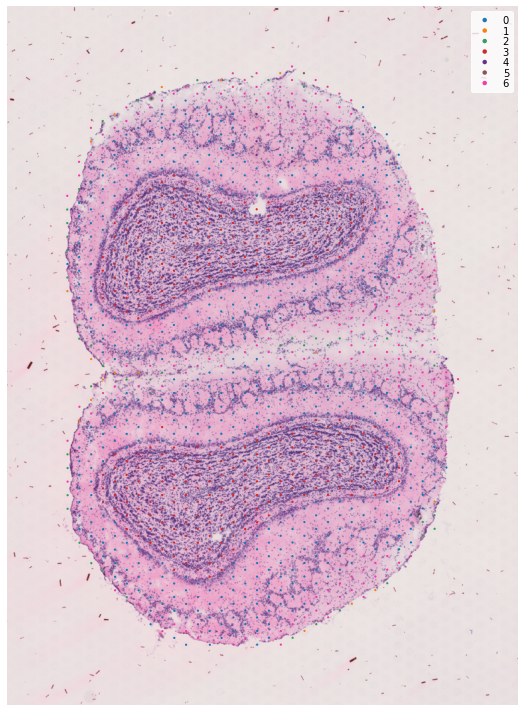

In [88]:
engine.cluster_reconstructed_data(reconstructed_data)

## Train edge detection classifier

In [11]:
from load_data import load_edge_detection_data
load_edge_detection_data(dataset_name)

(<torch.utils.data.dataloader.DataLoader at 0x7f35810fff70>,
 <torch.utils.data.dataloader.DataLoader at 0x7f35810ff700>)

In [12]:
from train import train_tiles_for_edges
train_tiles_for_edges(k_fold=5)

Fold : 0
EdgeDetectNN(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=24010, out_features=1024, bias=True)
  (fc2): Linear(in_features=24010, out_features=2, bias=True)
)


Train epoch 0/20: 100%|██████████| 32/32 [00:01<00:00, 25.22it/s]


Epoch #0 Train Loss: 1.0787136014822232, Accuracy: 55.078125
Epoch #0 Test Loss: 0.8396383344810446, Accuracy: 60.9375


Train epoch 1/20: 100%|██████████| 32/32 [00:01<00:00, 18.51it/s]


Epoch #1 Train Loss: 0.9771095560364507, Accuracy: 56.640625
Epoch #1 Test Loss: 0.8302852518052778, Accuracy: 60.9375


Train epoch 2/20: 100%|██████████| 32/32 [00:01<00:00, 17.39it/s]


Epoch #2 Train Loss: 0.9294405244837979, Accuracy: 57.291666666666664
Epoch #2 Test Loss: 0.8503853648660727, Accuracy: 53.645833333333336


Train epoch 3/20: 100%|██████████| 32/32 [00:01<00:00, 19.79it/s]


Epoch #3 Train Loss: 0.8975133929836431, Accuracy: 59.27734375
Epoch #3 Test Loss: 0.8434437012576959, Accuracy: 55.46875


Train epoch 4/20: 100%|██████████| 32/32 [00:01<00:00, 18.12it/s]


Epoch #4 Train Loss: 0.8687747163652797, Accuracy: 62.265625
Epoch #4 Test Loss: 0.8370772822427821, Accuracy: 56.25


Train epoch 5/20: 100%|██████████| 32/32 [00:01<00:00, 19.52it/s]


Epoch #5 Train Loss: 0.8455644444098568, Accuracy: 64.90885416666667
Epoch #5 Test Loss: 0.8336271593780957, Accuracy: 57.03125


Train epoch 6/20: 100%|██████████| 32/32 [00:01<00:00, 17.30it/s]


Epoch #6 Train Loss: 0.8234403292106333, Accuracy: 67.91294642857143
Epoch #6 Test Loss: 0.8307489351718427, Accuracy: 57.589285714285715


Train epoch 7/20: 100%|██████████| 32/32 [00:01<00:00, 20.38it/s]


Epoch #7 Train Loss: 0.8027260378839134, Accuracy: 70.41015625
Epoch #7 Test Loss: 0.8323251718307314, Accuracy: 57.8125


Train epoch 8/20: 100%|██████████| 32/32 [00:02<00:00, 13.74it/s]


Epoch #8 Train Loss: 0.7832569410420009, Accuracy: 72.52604166666667
Epoch #8 Test Loss: 0.8304552014640191, Accuracy: 58.333333333333336


Train epoch 9/20: 100%|██████████| 32/32 [00:01<00:00, 18.97it/s]


Epoch #9 Train Loss: 0.7653860273293203, Accuracy: 74.453125
Epoch #9 Test Loss: 0.8290121142569388, Accuracy: 58.90625


Train epoch 10/20: 100%|██████████| 32/32 [00:01<00:00, 17.23it/s]


Epoch #10 Train Loss: 0.746249446846182, Accuracy: 76.52698863636364
Epoch #10 Test Loss: 0.8273413077993056, Accuracy: 59.375


Train epoch 11/20: 100%|██████████| 32/32 [00:01<00:00, 16.94it/s]


Epoch #11 Train Loss: 0.7293494800217768, Accuracy: 78.05989583333333
Epoch #11 Test Loss: 0.8276660094427836, Accuracy: 59.635416666666664


Train epoch 12/20: 100%|██████████| 32/32 [00:01<00:00, 16.88it/s]


Epoch #12 Train Loss: 0.7117416390873479, Accuracy: 79.62740384615384
Epoch #12 Test Loss: 0.827160356827382, Accuracy: 59.97596153846154


Train epoch 13/20: 100%|██████████| 32/32 [00:01<00:00, 18.16it/s]


Epoch #13 Train Loss: 0.695133511468986, Accuracy: 81.02678571428571
Epoch #13 Test Loss: 0.8280536549867119, Accuracy: 60.15625


Train epoch 14/20: 100%|██████████| 32/32 [00:01<00:00, 18.38it/s]


Epoch #14 Train Loss: 0.6791850199039114, Accuracy: 82.23958333333333
Epoch #14 Test Loss: 0.8288502269164795, Accuracy: 60.3125


Train epoch 15/20: 100%|██████████| 32/32 [00:01<00:00, 16.84it/s]


Epoch #15 Train Loss: 0.664797563315363, Accuracy: 83.3251953125
Epoch #15 Test Loss: 0.8300240646317226, Accuracy: 60.44921875


Train epoch 16/20: 100%|██████████| 32/32 [00:01<00:00, 18.99it/s]


Epoch #16 Train Loss: 0.6507251985827907, Accuracy: 84.28308823529412
Epoch #16 Test Loss: 0.8305495993551526, Accuracy: 60.47794117647059


Train epoch 17/20: 100%|██████████| 32/32 [00:02<00:00, 14.99it/s]


Epoch #17 Train Loss: 0.6370585614881576, Accuracy: 85.13454861111111
Epoch #17 Test Loss: 0.8322955958045277, Accuracy: 60.50347222222222


Train epoch 18/20: 100%|██████████| 32/32 [00:01<00:00, 17.33it/s]


Epoch #18 Train Loss: 0.6237502908774669, Accuracy: 85.91694078947368
Epoch #18 Test Loss: 0.8375430170563235, Accuracy: 60.44407894736842


Train epoch 19/20: 100%|██████████| 32/32 [00:01<00:00, 17.32it/s]


Epoch #19 Train Loss: 0.6112205418657737, Accuracy: 86.62109375
Epoch #19 Test Loss: 0.8402325022094441, Accuracy: 60.46875
Fold : 1
EdgeDetectNN(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=24010, out_features=1024, bias=True)
  (fc2): Linear(in_features=24010, out_features=2, bias=True)
)


Train epoch 0/20: 100%|██████████| 32/32 [00:01<00:00, 18.95it/s]


Epoch #0 Train Loss: 0.6301471358905733, Accuracy: 85.15625
Epoch #0 Test Loss: 0.40431586511213713, Accuracy: 100.0


Train epoch 1/20: 100%|██████████| 32/32 [00:01<00:00, 16.55it/s]


Epoch #1 Train Loss: 0.5702651280576357, Accuracy: 88.0859375
Epoch #1 Test Loss: 0.3701043630003666, Accuracy: 100.0


Train epoch 2/20: 100%|██████████| 32/32 [00:01<00:00, 17.27it/s]


Epoch #2 Train Loss: 0.5359052835451763, Accuracy: 89.84375
Epoch #2 Test Loss: 0.36315920105835237, Accuracy: 100.0


Train epoch 3/20: 100%|██████████| 32/32 [00:01<00:00, 16.44it/s]


Epoch #3 Train Loss: 0.512761352463781, Accuracy: 90.625
Epoch #3 Test Loss: 0.35019178269049295, Accuracy: 100.0


Train epoch 4/20: 100%|██████████| 32/32 [00:01<00:00, 20.17it/s]


Epoch #4 Train Loss: 0.4942325874696725, Accuracy: 91.5625
Epoch #4 Test Loss: 0.3463747819403716, Accuracy: 100.0


Train epoch 5/20: 100%|██████████| 32/32 [00:01<00:00, 17.53it/s]


Epoch #5 Train Loss: 0.4751305809885373, Accuracy: 92.31770833333333
Epoch #5 Test Loss: 0.34235541166404426, Accuracy: 100.0


Train epoch 6/20: 100%|██████████| 32/32 [00:02<00:00, 15.09it/s]


Epoch #6 Train Loss: 0.45603896750228284, Accuracy: 93.24776785714286
Epoch #6 Test Loss: 0.33631617587515544, Accuracy: 100.0


Train epoch 7/20: 100%|██████████| 32/32 [00:02<00:00, 15.29it/s]


Epoch #7 Train Loss: 0.4399595657268622, Accuracy: 93.9453125
Epoch #7 Test Loss: 0.33392245354078953, Accuracy: 99.8046875


Train epoch 8/20: 100%|██████████| 32/32 [00:01<00:00, 16.20it/s]


Epoch #8 Train Loss: 0.42451542576823836, Accuracy: 94.61805555555556
Epoch #8 Test Loss: 0.32832822674787665, Accuracy: 99.82638888888889


Train epoch 9/20: 100%|██████████| 32/32 [00:02<00:00, 14.32it/s]


Epoch #9 Train Loss: 0.4105845562274868, Accuracy: 95.15625
Epoch #9 Test Loss: 0.32339314223385857, Accuracy: 99.84375


Train epoch 10/20: 100%|██████████| 32/32 [00:01<00:00, 18.87it/s]


Epoch #10 Train Loss: 0.39767879125865524, Accuracy: 95.56107954545455
Epoch #10 Test Loss: 0.31983627009403137, Accuracy: 99.85795454545455


Train epoch 11/20: 100%|██████████| 32/32 [00:02<00:00, 15.94it/s]


Epoch #11 Train Loss: 0.3855457011837734, Accuracy: 95.93098958333333
Epoch #11 Test Loss: 0.3177759316313693, Accuracy: 99.86979166666667


Train epoch 12/20: 100%|██████████| 32/32 [00:01<00:00, 16.37it/s]


Epoch #12 Train Loss: 0.3743966052608857, Accuracy: 96.24399038461539
Epoch #12 Test Loss: 0.3136975032902314, Accuracy: 99.8798076923077


Train epoch 13/20: 100%|██████████| 32/32 [00:02<00:00, 15.03it/s]


Epoch #13 Train Loss: 0.3639156646561711, Accuracy: 96.51227678571429
Epoch #13 Test Loss: 0.3101814058976641, Accuracy: 99.88839285714286


Train epoch 14/20: 100%|██████████| 32/32 [00:01<00:00, 17.11it/s]


Epoch #14 Train Loss: 0.35427992136146624, Accuracy: 96.74479166666667
Epoch #14 Test Loss: 0.30725032153114695, Accuracy: 99.89583333333333


Train epoch 15/20: 100%|██████████| 32/32 [00:02<00:00, 13.83it/s]


Epoch #15 Train Loss: 0.34558605447252916, Accuracy: 96.9482421875
Epoch #15 Test Loss: 0.30550678298345924, Accuracy: 99.90234375


Train epoch 16/20: 100%|██████████| 32/32 [00:02<00:00, 15.62it/s]


Epoch #16 Train Loss: 0.33725897354110057, Accuracy: 97.12775735294117
Epoch #16 Test Loss: 0.3034527151956553, Accuracy: 99.90808823529412


Train epoch 17/20: 100%|██████████| 32/32 [00:02<00:00, 15.61it/s]


Epoch #17 Train Loss: 0.329580801230961, Accuracy: 97.28732638888889
Epoch #17 Test Loss: 0.3011579756972921, Accuracy: 99.91319444444444


Train epoch 18/20: 100%|██████████| 32/32 [00:01<00:00, 16.44it/s]


Epoch #18 Train Loss: 0.32234771336254237, Accuracy: 97.43009868421052
Epoch #18 Test Loss: 0.2992680219958554, Accuracy: 99.91776315789474


Train epoch 19/20: 100%|██████████| 32/32 [00:02<00:00, 15.95it/s]


Epoch #19 Train Loss: 0.31567170764691427, Accuracy: 97.55859375
Epoch #19 Test Loss: 0.29744455582572915, Accuracy: 99.921875
Fold : 2
EdgeDetectNN(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=24010, out_features=1024, bias=True)
  (fc2): Linear(in_features=24010, out_features=2, bias=True)
)


Train epoch 0/20: 100%|██████████| 32/32 [00:02<00:00, 15.41it/s]


Epoch #0 Train Loss: 0.2407917168830555, Accuracy: 99.21875
Epoch #0 Test Loss: 0.14718559236502626, Accuracy: 100.0


Train epoch 1/20: 100%|██████████| 32/32 [00:01<00:00, 16.47it/s]


Epoch #1 Train Loss: 0.20787106240667985, Accuracy: 99.609375
Epoch #1 Test Loss: 0.13573916874846156, Accuracy: 100.0


Train epoch 2/20: 100%|██████████| 32/32 [00:02<00:00, 13.73it/s]


Epoch #2 Train Loss: 0.18863895737715722, Accuracy: 99.73958333333333
Epoch #2 Test Loss: 0.13116555141802774, Accuracy: 100.0


Train epoch 3/20: 100%|██████████| 32/32 [00:02<00:00, 14.17it/s]


Epoch #3 Train Loss: 0.17485787540906403, Accuracy: 99.8046875
Epoch #3 Test Loss: 0.12661407281903242, Accuracy: 100.0


Train epoch 4/20: 100%|██████████| 32/32 [00:01<00:00, 19.57it/s]


Epoch #4 Train Loss: 0.16466836923220926, Accuracy: 99.84375
Epoch #4 Test Loss: 0.12585199896584134, Accuracy: 100.0


Train epoch 5/20: 100%|██████████| 32/32 [00:02<00:00, 14.09it/s]


Epoch #5 Train Loss: 0.15637035421510034, Accuracy: 99.86979166666667
Epoch #5 Test Loss: 0.12318618160433926, Accuracy: 100.0


Train epoch 6/20: 100%|██████████| 32/32 [00:02<00:00, 14.28it/s]


Epoch #6 Train Loss: 0.14962943205471718, Accuracy: 99.88839285714286
Epoch #6 Test Loss: 0.12175111556737579, Accuracy: 100.0


Train epoch 7/20: 100%|██████████| 32/32 [00:02<00:00, 14.28it/s]


Epoch #7 Train Loss: 0.14343291221116547, Accuracy: 99.90234375
Epoch #7 Test Loss: 0.12263841177208143, Accuracy: 100.0


Train epoch 8/20: 100%|██████████| 32/32 [00:02<00:00, 12.20it/s]


Epoch #8 Train Loss: 0.1386079136794438, Accuracy: 99.91319444444444
Epoch #8 Test Loss: 0.1214165771156168, Accuracy: 100.0


Train epoch 9/20: 100%|██████████| 32/32 [00:02<00:00, 14.83it/s]


Epoch #9 Train Loss: 0.1343497235498629, Accuracy: 99.921875
Epoch #9 Test Loss: 0.12022324150419074, Accuracy: 100.0


Train epoch 10/20: 100%|██████████| 32/32 [00:02<00:00, 12.85it/s]


Epoch #10 Train Loss: 0.13016492988077336, Accuracy: 99.92897727272727
Epoch #10 Test Loss: 0.11910956817583788, Accuracy: 100.0


Train epoch 11/20: 100%|██████████| 32/32 [00:02<00:00, 12.09it/s]


Epoch #11 Train Loss: 0.12614509403161597, Accuracy: 99.93489583333333
Epoch #11 Test Loss: 0.11811982489434755, Accuracy: 100.0


Train epoch 12/20: 100%|██████████| 32/32 [00:02<00:00, 10.72it/s]


Epoch #12 Train Loss: 0.12252597513552597, Accuracy: 99.93990384615384
Epoch #12 Test Loss: 0.11742451439848996, Accuracy: 100.0


Train epoch 13/20: 100%|██████████| 32/32 [00:03<00:00,  9.05it/s]


Epoch #13 Train Loss: 0.1191873709304607, Accuracy: 99.94419642857143
Epoch #13 Test Loss: 0.11681727111183136, Accuracy: 100.0


Train epoch 14/20: 100%|██████████| 32/32 [00:03<00:00, 10.01it/s]


Epoch #14 Train Loss: 0.11616831733686424, Accuracy: 99.94791666666667
Epoch #14 Test Loss: 0.11631197991180998, Accuracy: 100.0


Train epoch 15/20: 100%|██████████| 32/32 [00:04<00:00,  7.77it/s]


Epoch #15 Train Loss: 0.11331338905405708, Accuracy: 99.951171875
Epoch #15 Test Loss: 0.11620922494951777, Accuracy: 100.0


Train epoch 16/20: 100%|██████████| 32/32 [00:03<00:00,  9.36it/s]


Epoch #16 Train Loss: 0.11071011313969809, Accuracy: 99.95404411764706
Epoch #16 Test Loss: 0.11582521786725473, Accuracy: 100.0


Train epoch 17/20: 100%|██████████| 32/32 [00:02<00:00, 11.86it/s]


Epoch #17 Train Loss: 0.10820765761721804, Accuracy: 99.95659722222223
Epoch #17 Test Loss: 0.11552446403104878, Accuracy: 100.0


Train epoch 18/20: 100%|██████████| 32/32 [00:02<00:00, 14.48it/s]


Epoch #18 Train Loss: 0.10592675910003535, Accuracy: 99.95888157894737
Epoch #18 Test Loss: 0.11511788179330669, Accuracy: 100.0


Train epoch 19/20: 100%|██████████| 32/32 [00:02<00:00, 12.77it/s]


Epoch #19 Train Loss: 0.10373894056572808, Accuracy: 99.9609375
Epoch #19 Test Loss: 0.11521766977055221, Accuracy: 100.0
Fold : 3
EdgeDetectNN(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=24010, out_features=1024, bias=True)
  (fc2): Linear(in_features=24010, out_features=2, bias=True)
)


Train epoch 0/20: 100%|██████████| 32/32 [00:02<00:00, 15.93it/s]


Epoch #0 Train Loss: 0.14731885024732982, Accuracy: 99.609375
Epoch #0 Test Loss: 0.05848115568486623, Accuracy: 100.0


Train epoch 1/20: 100%|██████████| 32/32 [00:01<00:00, 16.70it/s]


Epoch #1 Train Loss: 0.11704209993682085, Accuracy: 99.8046875
Epoch #1 Test Loss: 0.053474307009084614, Accuracy: 100.0


Train epoch 2/20: 100%|██████████| 32/32 [00:01<00:00, 18.81it/s]


Epoch #2 Train Loss: 0.10182410160903423, Accuracy: 99.86979166666667
Epoch #2 Test Loss: 0.05163854007772392, Accuracy: 100.0


Train epoch 3/20: 100%|██████████| 32/32 [00:02<00:00, 15.31it/s]


Epoch #3 Train Loss: 0.09345861155460983, Accuracy: 99.90234375
Epoch #3 Test Loss: 0.04967897774762759, Accuracy: 100.0


Train epoch 4/20: 100%|██████████| 32/32 [00:01<00:00, 17.20it/s]


Epoch #4 Train Loss: 0.08687362530946582, Accuracy: 99.921875
Epoch #4 Test Loss: 0.04889245818356886, Accuracy: 100.0


Train epoch 5/20: 100%|██████████| 32/32 [00:02<00:00, 14.34it/s]


Epoch #5 Train Loss: 0.0821009756886475, Accuracy: 99.93489583333333
Epoch #5 Test Loss: 0.04812535348615621, Accuracy: 100.0


Train epoch 6/20: 100%|██████████| 32/32 [00:02<00:00, 15.50it/s]


Epoch #6 Train Loss: 0.07826170907666005, Accuracy: 99.94419642857143
Epoch #6 Test Loss: 0.04717216575056329, Accuracy: 100.0


Train epoch 7/20: 100%|██████████| 32/32 [00:02<00:00, 15.20it/s]


Epoch #7 Train Loss: 0.07500772970492112, Accuracy: 99.951171875
Epoch #7 Test Loss: 0.046500973118258425, Accuracy: 100.0


Train epoch 8/20: 100%|██████████| 32/32 [00:02<00:00, 12.44it/s]


Epoch #8 Train Loss: 0.07227552359582996, Accuracy: 99.95659722222223
Epoch #8 Test Loss: 0.04615897637003812, Accuracy: 100.0


Train epoch 9/20: 100%|██████████| 32/32 [00:02<00:00, 14.67it/s]


Epoch #9 Train Loss: 0.06991979860070807, Accuracy: 99.9609375
Epoch #9 Test Loss: 0.045607523924812154, Accuracy: 100.0


Train epoch 10/20: 100%|██████████| 32/32 [00:02<00:00, 13.87it/s]


Epoch #10 Train Loss: 0.06787059734167936, Accuracy: 99.96448863636364
Epoch #10 Test Loss: 0.045220335305008616, Accuracy: 100.0


Train epoch 11/20: 100%|██████████| 32/32 [00:02<00:00, 15.04it/s]


Epoch #11 Train Loss: 0.06613291990998527, Accuracy: 99.96744791666667
Epoch #11 Test Loss: 0.04474769887082022, Accuracy: 100.0


Train epoch 12/20: 100%|██████████| 32/32 [00:02<00:00, 15.46it/s]


Epoch #12 Train Loss: 0.0644342955485229, Accuracy: 99.96995192307692
Epoch #12 Test Loss: 0.04435514201390751, Accuracy: 100.0


Train epoch 13/20: 100%|██████████| 32/32 [00:01<00:00, 17.79it/s]


Epoch #13 Train Loss: 0.0628899081543465, Accuracy: 99.97209821428571
Epoch #13 Test Loss: 0.04400089079731007, Accuracy: 100.0


Train epoch 14/20: 100%|██████████| 32/32 [00:01<00:00, 18.34it/s]


Epoch #14 Train Loss: 0.06147076168037638, Accuracy: 99.97395833333333
Epoch #14 Test Loss: 0.04365248335676694, Accuracy: 100.0


Train epoch 15/20: 100%|██████████| 32/32 [00:01<00:00, 18.52it/s]


Epoch #15 Train Loss: 0.06017752854310438, Accuracy: 99.9755859375
Epoch #15 Test Loss: 0.04333555528775062, Accuracy: 100.0


Train epoch 16/20: 100%|██████████| 32/32 [00:01<00:00, 16.53it/s]


Epoch #16 Train Loss: 0.05896059276576175, Accuracy: 99.97702205882354
Epoch #16 Test Loss: 0.04304246683014702, Accuracy: 100.0


Train epoch 17/20: 100%|██████████| 32/32 [00:01<00:00, 19.27it/s]


Epoch #17 Train Loss: 0.05781913135722142, Accuracy: 99.97829861111111
Epoch #17 Test Loss: 0.042775106643476425, Accuracy: 100.0


Train epoch 18/20: 100%|██████████| 32/32 [00:01<00:00, 16.97it/s]


Epoch #18 Train Loss: 0.056751070455317236, Accuracy: 99.97944078947368
Epoch #18 Test Loss: 0.04254676729459761, Accuracy: 100.0


Train epoch 19/20: 100%|██████████| 32/32 [00:01<00:00, 18.81it/s]


Epoch #19 Train Loss: 0.0557680683112717, Accuracy: 99.98046875
Epoch #19 Test Loss: 0.042309690583100634, Accuracy: 100.0
Fold : 4
EdgeDetectNN(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=24010, out_features=1024, bias=True)
  (fc2): Linear(in_features=24010, out_features=2, bias=True)
)


Train epoch 0/20: 100%|██████████| 32/32 [00:01<00:00, 17.68it/s]


Epoch #0 Train Loss: 0.06216344106513539, Accuracy: 100.0
Epoch #0 Test Loss: 0.03153727166921882, Accuracy: 100.0


Train epoch 1/20: 100%|██████████| 32/32 [00:01<00:00, 17.56it/s]


Epoch #1 Train Loss: 0.05171102185899436, Accuracy: 100.0
Epoch #1 Test Loss: 0.032149147899941236, Accuracy: 100.0


Train epoch 2/20: 100%|██████████| 32/32 [00:02<00:00, 14.10it/s]


Epoch #2 Train Loss: 0.046135177633290565, Accuracy: 100.0
Epoch #2 Test Loss: 0.030403688207217915, Accuracy: 100.0


Train epoch 3/20: 100%|██████████| 32/32 [00:01<00:00, 18.56it/s]


Epoch #3 Train Loss: 0.04261613363465882, Accuracy: 100.0
Epoch #3 Test Loss: 0.02969257011053684, Accuracy: 100.0


Train epoch 4/20: 100%|██████████| 32/32 [00:01<00:00, 16.29it/s]


Epoch #4 Train Loss: 0.04021530193839355, Accuracy: 100.0
Epoch #4 Test Loss: 0.02946571087176856, Accuracy: 100.0


Train epoch 5/20: 100%|██████████| 32/32 [00:01<00:00, 17.19it/s]


Epoch #5 Train Loss: 0.03828447115396489, Accuracy: 100.0
Epoch #5 Test Loss: 0.029022820379029073, Accuracy: 100.0


Train epoch 6/20: 100%|██████████| 32/32 [00:01<00:00, 18.15it/s]


Epoch #6 Train Loss: 0.03669019990509983, Accuracy: 100.0
Epoch #6 Test Loss: 0.028768721968591374, Accuracy: 100.0


Train epoch 7/20: 100%|██████████| 32/32 [00:01<00:00, 18.67it/s]


Epoch #7 Train Loss: 0.03536373378689792, Accuracy: 100.0
Epoch #7 Test Loss: 0.02858534453097989, Accuracy: 100.0


Train epoch 8/20: 100%|██████████| 32/32 [00:01<00:00, 16.94it/s]


Epoch #8 Train Loss: 0.034213238902141105, Accuracy: 100.0
Epoch #8 Test Loss: 0.028280232472094068, Accuracy: 100.0


Train epoch 9/20: 100%|██████████| 32/32 [00:01<00:00, 18.04it/s]


Epoch #9 Train Loss: 0.03318564499966375, Accuracy: 100.0
Epoch #9 Test Loss: 0.028054625806120524, Accuracy: 100.0


Train epoch 10/20: 100%|██████████| 32/32 [00:01<00:00, 20.05it/s]


Epoch #10 Train Loss: 0.03230805391016157, Accuracy: 100.0
Epoch #10 Test Loss: 0.02786959896444976, Accuracy: 100.0


Train epoch 11/20: 100%|██████████| 32/32 [00:01<00:00, 16.47it/s]


Epoch #11 Train Loss: 0.0315366954920667, Accuracy: 100.0
Epoch #11 Test Loss: 0.027663683339913987, Accuracy: 100.0


Train epoch 12/20: 100%|██████████| 32/32 [00:01<00:00, 16.17it/s]


Epoch #12 Train Loss: 0.030763719144242994, Accuracy: 100.0
Epoch #12 Test Loss: 0.027474603955066665, Accuracy: 100.0


Train epoch 13/20: 100%|██████████| 32/32 [00:01<00:00, 18.11it/s]


Epoch #13 Train Loss: 0.03007215209796036, Accuracy: 100.0
Epoch #13 Test Loss: 0.027311343179470902, Accuracy: 100.0


Train epoch 14/20: 100%|██████████| 32/32 [00:01<00:00, 19.35it/s]


Epoch #14 Train Loss: 0.02941807413350872, Accuracy: 100.0
Epoch #14 Test Loss: 0.02731583434148522, Accuracy: 100.0


Train epoch 15/20: 100%|██████████| 32/32 [00:02<00:00, 14.76it/s]


Epoch #15 Train Loss: 0.028800377331563362, Accuracy: 100.0
Epoch #15 Test Loss: 0.027227953297294435, Accuracy: 100.0


Train epoch 16/20: 100%|██████████| 32/32 [00:01<00:00, 17.94it/s]


Epoch #16 Train Loss: 0.02821985343285593, Accuracy: 100.0
Epoch #16 Test Loss: 0.027241525626738722, Accuracy: 100.0


Train epoch 17/20: 100%|██████████| 32/32 [00:01<00:00, 16.31it/s]


Epoch #17 Train Loss: 0.027685371579953728, Accuracy: 100.0
Epoch #17 Test Loss: 0.027245468359454097, Accuracy: 100.0


Train epoch 18/20: 100%|██████████| 32/32 [00:01<00:00, 19.50it/s]


Epoch #18 Train Loss: 0.02718337635620612, Accuracy: 100.0
Epoch #18 Test Loss: 0.027240658125342786, Accuracy: 100.0


Train epoch 19/20: 100%|██████████| 32/32 [00:01<00:00, 17.71it/s]


Epoch #19 Train Loss: 0.02669975660175396, Accuracy: 100.0
Epoch #19 Test Loss: 0.027303864857945292, Accuracy: 100.0


/usr/local/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
Tiling image: 100%|██████████ [ time left: 00:00 ]
/FPST/code/train.py:264: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  adata.obs.loc[batch_idx: batch_idx+8,'has_edge'] = predicted
Train epoch 0/20: 100%|██████████| 32/32 [00:01<00:00, 18.88it/s]


Epoch #0 Train Loss: 0.014501139638637752, Accuracy: 100.0
Epoch #0 Test Loss: 0.025052399077526342, Accuracy: 100.0


Train epoch 1/20: 100%|██████████| 32/32 [00:02<00:00, 15.98it/s]


Epoch #1 Train Loss: 0.01419497030006868, Accuracy: 100.0
Epoch #1 Test Loss: 0.024991630641005423, Accuracy: 100.0


Train epoch 2/20: 100%|██████████| 32/32 [00:01<00:00, 19.50it/s]


Epoch #2 Train Loss: 0.01394674893679455, Accuracy: 100.0
Epoch #2 Test Loss: 0.02480364568944541, Accuracy: 100.0


Train epoch 3/20: 100%|██████████| 32/32 [00:02<00:00, 14.29it/s]


Epoch #3 Train Loss: 0.013714288352118784, Accuracy: 100.0
Epoch #3 Test Loss: 0.024771945170027402, Accuracy: 100.0


Train epoch 4/20: 100%|██████████| 32/32 [00:01<00:00, 18.50it/s]


Epoch #4 Train Loss: 0.013506470359415724, Accuracy: 100.0
Epoch #4 Test Loss: 0.025259330135179937, Accuracy: 100.0


Train epoch 5/20: 100%|██████████| 32/32 [00:02<00:00, 15.62it/s]


Epoch #5 Train Loss: 0.013358172491995635, Accuracy: 100.0
Epoch #5 Test Loss: 0.025452605689428365, Accuracy: 100.0


Train epoch 6/20: 100%|██████████| 32/32 [00:01<00:00, 18.77it/s]


Epoch #6 Train Loss: 0.013149402555964291, Accuracy: 100.0
Epoch #6 Test Loss: 0.025525214461765654, Accuracy: 100.0


Train epoch 7/20: 100%|██████████| 32/32 [00:02<00:00, 15.79it/s]


Epoch #7 Train Loss: 0.01297596802112671, Accuracy: 100.0
Epoch #7 Test Loss: 0.02581435997585591, Accuracy: 100.0


Train epoch 8/20: 100%|██████████| 32/32 [00:01<00:00, 19.69it/s]


Epoch #8 Train Loss: 0.012815438502054126, Accuracy: 100.0
Epoch #8 Test Loss: 0.02564717061546994, Accuracy: 100.0


Train epoch 9/20: 100%|██████████| 32/32 [00:01<00:00, 17.21it/s]


Epoch #9 Train Loss: 0.012640135566685324, Accuracy: 100.0
Epoch #9 Test Loss: 0.025940531075310868, Accuracy: 100.0


Train epoch 10/20: 100%|██████████| 32/32 [00:01<00:00, 17.99it/s]


Epoch #10 Train Loss: 0.012470461685077617, Accuracy: 100.0
Epoch #10 Test Loss: 0.025786112211807644, Accuracy: 100.0


Train epoch 11/20: 100%|██████████| 32/32 [00:01<00:00, 16.64it/s]


Epoch #11 Train Loss: 0.012329073131770901, Accuracy: 100.0
Epoch #11 Test Loss: 0.025836252457008702, Accuracy: 100.0


Train epoch 12/20: 100%|██████████| 32/32 [00:02<00:00, 13.58it/s]


Epoch #12 Train Loss: 0.012172968591293647, Accuracy: 100.0
Epoch #12 Test Loss: 0.02601979098078594, Accuracy: 100.0


Train epoch 13/20: 100%|██████████| 32/32 [00:02<00:00, 15.11it/s]


Epoch #13 Train Loss: 0.01203201674925979, Accuracy: 100.0
Epoch #13 Test Loss: 0.02606094920665904, Accuracy: 100.0


Train epoch 14/20: 100%|██████████| 32/32 [00:01<00:00, 16.20it/s]


Epoch #14 Train Loss: 0.01188868137687421, Accuracy: 100.0
Epoch #14 Test Loss: 0.026219460405535952, Accuracy: 100.0


Train epoch 15/20: 100%|██████████| 32/32 [00:01<00:00, 17.70it/s]


Epoch #15 Train Loss: 0.0117501782311707, Accuracy: 100.0
Epoch #15 Test Loss: 0.026103656657049015, Accuracy: 100.0


Train epoch 16/20: 100%|██████████| 32/32 [00:01<00:00, 20.06it/s]


Epoch #16 Train Loss: 0.011617893271210435, Accuracy: 100.0
Epoch #16 Test Loss: 0.026259454950792693, Accuracy: 100.0


Train epoch 17/20: 100%|██████████| 32/32 [00:01<00:00, 16.20it/s]


Epoch #17 Train Loss: 0.011487337311763225, Accuracy: 100.0
Epoch #17 Test Loss: 0.0261798930640879, Accuracy: 100.0


Train epoch 18/20: 100%|██████████| 32/32 [00:01<00:00, 16.69it/s]


Epoch #18 Train Loss: 0.011358230041058058, Accuracy: 100.0
Epoch #18 Test Loss: 0.02608513966402447, Accuracy: 100.0


Train epoch 19/20: 100%|██████████| 32/32 [00:02<00:00, 15.29it/s]


Epoch #19 Train Loss: 0.011239957575827991, Accuracy: 100.0
Epoch #19 Test Loss: 0.02600907515010709, Accuracy: 100.0


# Train per spot

In [13]:
from load_data import load_visium_data
load_visium_data(dataset_name, 'spots_data')

/usr/local/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


SpotsData(dataset='', batch_size=128, num_workers=1, device='cpu', top_expressed_genes_number=100)

In [17]:
from train import train_data_for_imputation
nmf_train_losses, nmf_test_losses = train_data_for_imputation(dataset_name = 'Visium_Mouse_Olfactory_Bulb',
                              data_type = 'spots_data')

/usr/local/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


NMF(
  (embedding_genes): Embedding(32286, 20)
  (embedding_spots): Embedding(1186, 20)
)


Train epoch 0/10: 100%|██████████| 935/935 [00:14<00:00, 65.64it/s]


Epoch #0 Train Loss: 3.39982693106366
Epoch #0 Test Loss: 3.5011417853490228


Train epoch 1/10: 100%|██████████| 935/935 [00:17<00:00, 53.71it/s]


Epoch #1 Train Loss: 3.3952330590238207
Epoch #1 Test Loss: 3.501129324051268


Train epoch 2/10: 100%|██████████| 935/935 [00:10<00:00, 90.73it/s] 


Epoch #2 Train Loss: 3.378724857867592
Epoch #2 Test Loss: 3.501483608516341


Train epoch 3/10: 100%|██████████| 935/935 [00:10<00:00, 92.46it/s] 


Epoch #3 Train Loss: 3.340915964917286
Epoch #3 Test Loss: 3.5024498570179508


Train epoch 4/10: 100%|██████████| 935/935 [00:10<00:00, 86.20it/s] 


Epoch #4 Train Loss: 3.274502641082031
Epoch #4 Test Loss: 3.5044910403123644


Train epoch 5/10: 100%|██████████| 935/935 [00:10<00:00, 90.56it/s] 


Epoch #5 Train Loss: 3.1769633735429683
Epoch #5 Test Loss: 3.508099165340543


Train epoch 6/10: 100%|██████████| 935/935 [00:11<00:00, 79.66it/s] 


Epoch #6 Train Loss: 3.0531051064482155
Epoch #6 Test Loss: 3.5135193805220166


Train epoch 7/10: 100%|██████████| 935/935 [00:14<00:00, 63.88it/s]


Epoch #7 Train Loss: 2.9158378127593068
Epoch #7 Test Loss: 3.5202939184810003


Train epoch 8/10: 100%|██████████| 935/935 [00:16<00:00, 55.60it/s]


Epoch #8 Train Loss: 2.7795001988795693
Epoch #8 Test Loss: 3.527321787556801


Train epoch 9/10: 100%|██████████| 935/935 [00:13<00:00, 71.88it/s]


Epoch #9 Train Loss: 2.6522572381087746
Epoch #9 Test Loss: 3.533852347978964


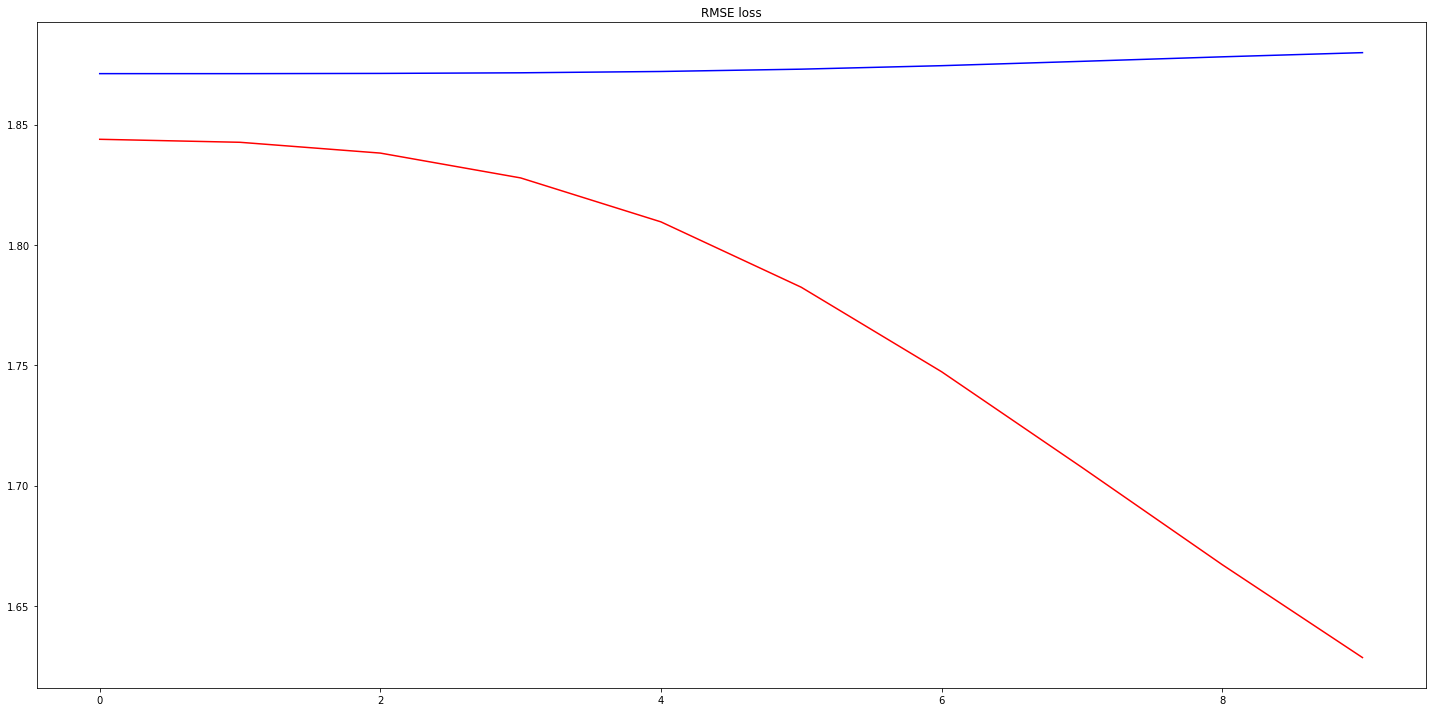

In [23]:
plot_train_vs_test(nmf_train_losses, nmf_test_losses, "RMSE loss")

In [22]:
nmf_train_losses

array([3.39982693, 3.39523306, 3.37872486, 3.34091596, 3.27450264,
       3.17696337, 3.05310511, 2.91583781, 2.7795002 , 2.65225724])

# NN- MF

In [ ]:
%load_ext autoreload
%autoreload 2
from models import NNMF
from torch import nn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1 Linear Layer

In [ ]:
params = {
    'learning_rate': 0.001,
    'optimizer': "RMSprop",
    'latent_dim': 20,
    'batch_size': BATCH_SIZE,
    'layers_sizes': [(20,10)]
}

In [ ]:
nnmf_model = NNMF(number_of_genes, number_of_spots, params, DEVICE)

In [ ]:
train_nnmf = engine(model = nnmf_model,
                    model_name = 'NNMF',
                    params = params,
                    epochs = 10,
                    dl_train = dataset.dl_train_top_genes,
                    dl_test = dataset.dl_test_top_genes,
                    device = DEVICE)

NNMF(
  (embedding_genes): Embedding(32286, 20)
  (embedding_spots): Embedding(1186, 20)
  (linear_layers): Sequential(
    (0): Linear(in_features=20, out_features=10, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)


In [ ]:
nnmf_train_losses, nnmf_test_losses = train_nnmf.execute()

Train epoch 0/10: 100%|██████████████████████████████████████████████████████████████| 750/750 [00:12<00:00, 60.39it/s]


Epoch #0 Train Loss: 1.715077950765421
Epoch #0 Test Loss: 1.1432739220273862


Train epoch 1/10: 100%|██████████████████████████████████████████████████████████████| 750/750 [00:12<00:00, 59.48it/s]


Epoch #1 Train Loss: 1.4558057859680813
Epoch #1 Test Loss: 1.1426385038114741


Train epoch 2/10: 100%|██████████████████████████████████████████████████████████████| 750/750 [00:12<00:00, 58.66it/s]


Epoch #2 Train Loss: 1.3583749468207718
Epoch #2 Test Loss: 1.1421958867106463


Train epoch 3/10: 100%|██████████████████████████████████████████████████████████████| 750/750 [00:12<00:00, 59.22it/s]


Epoch #3 Train Loss: 1.3069062600394739
Epoch #3 Test Loss: 1.1418163653589695


Train epoch 4/10: 100%|██████████████████████████████████████████████████████████████| 750/750 [00:12<00:00, 59.97it/s]


Epoch #4 Train Loss: 1.2750337305282085
Epoch #4 Test Loss: 1.1420464775417325


Train epoch 5/10: 100%|██████████████████████████████████████████████████████████████| 750/750 [00:12<00:00, 60.69it/s]


Epoch #5 Train Loss: 1.2533327516711268
Epoch #5 Test Loss: 1.1421073479159147


Train epoch 6/10: 100%|██████████████████████████████████████████████████████████████| 750/750 [00:12<00:00, 60.12it/s]


Epoch #6 Train Loss: 1.2375957593478204
Epoch #6 Test Loss: 1.1420722943277333


Train epoch 7/10: 100%|██████████████████████████████████████████████████████████████| 750/750 [00:12<00:00, 59.55it/s]


Epoch #7 Train Loss: 1.2256633870287823
Epoch #7 Test Loss: 1.1419659700887672


Train epoch 8/10: 100%|██████████████████████████████████████████████████████████████| 750/750 [00:12<00:00, 60.43it/s]


Epoch #8 Train Loss: 1.2162969217632982
Epoch #8 Test Loss: 1.1419787936257435


Train epoch 9/10: 100%|██████████████████████████████████████████████████████████████| 750/750 [00:12<00:00, 60.14it/s]


Epoch #9 Train Loss: 1.2087504861272487
Epoch #9 Test Loss: 1.1419060227512068


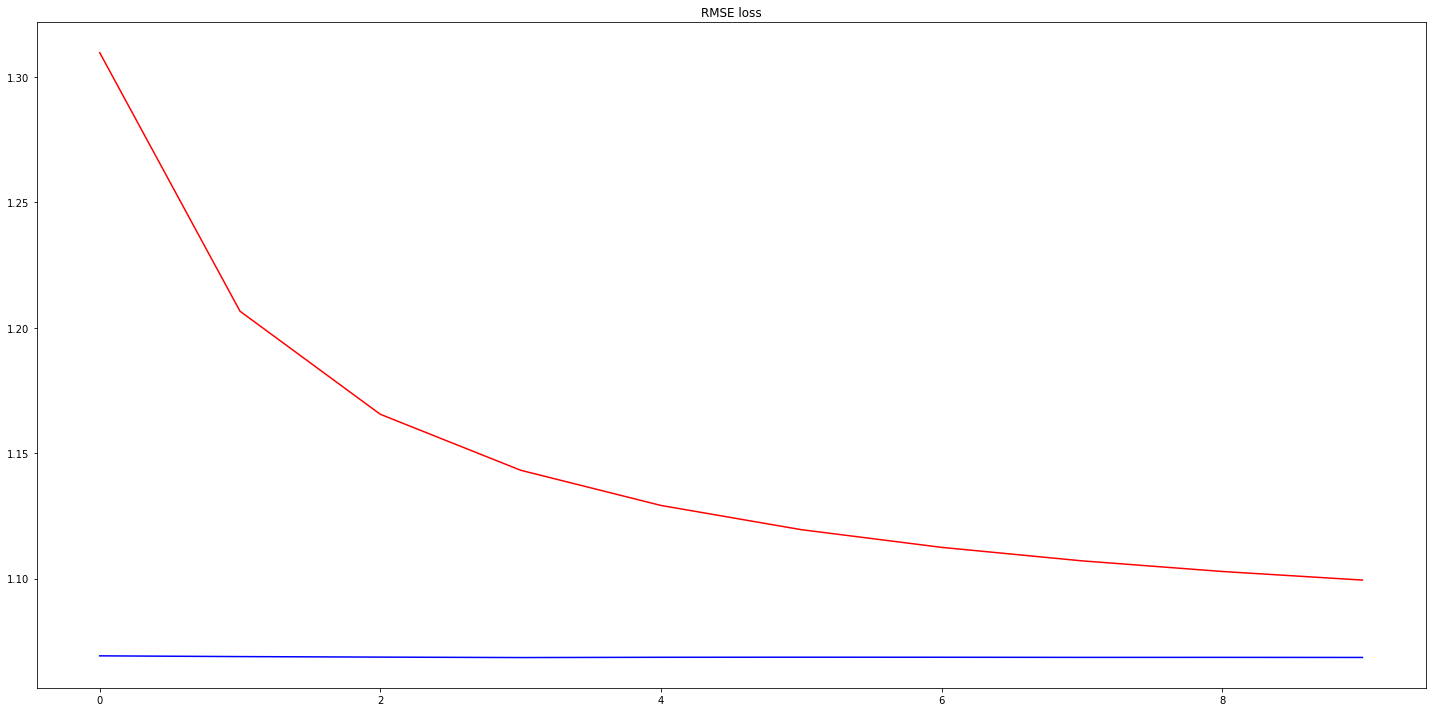

In [ ]:
plot_train_vs_test(nnmf_train_losses, nnmf_test_losses, "RMSE loss")

In [ ]:
df_expressions_preds, df_expressions_true, reconstructed_data = engine.create_reconstructed_data(nnmf_model, dataset, data, DEVICE)

  (0, 18)	5.0
  (0, 26)	2.0
  (0, 73)	2.0
  (0, 78)	3.0
  (0, 55)	2.0
  (0, 72)	1.0
  (0, 80)	3.0
  (0, 40)	2.0
  (0, 62)	1.0
  (0, 84)	1.0
  (0, 0)	1.0
  (0, 47)	1.0
  (0, 35)	2.0
  (0, 54)	2.0
  (0, 25)	3.0
  (0, 31)	2.0
  (0, 81)	2.0
  (0, 52)	1.0
  (0, 3)	2.0
  (0, 71)	1.0
  (0, 70)	2.0
  (0, 65)	1.0
  (0, 24)	1.0
  (0, 27)	7.0
  (0, 51)	2.0
  :	:
  (1184, 56)	23.0
  (1184, 49)	9.0
  (1184, 36)	15.0
  (1184, 7)	24.0
  (1184, 64)	18.0
  (1184, 9)	17.0
  (1184, 68)	20.0
  (1184, 44)	13.0
  (1184, 5)	13.0
  (1184, 10)	25.0
  (1184, 22)	24.0
  (1184, 16)	32.0
  (1184, 23)	34.0
  (1184, 37)	19.0
  (1184, 85)	24.0
  (1184, 95)	196.0
  (1184, 96)	125.0
  (1184, 91)	891.0
  (1184, 92)	499.0
  (1184, 90)	524.0
  (1184, 93)	682.0
  (1184, 97)	42.0
  (1184, 98)	260.0
  (1184, 99)	36.0
  (1184, 94)	295.0 [[list([3.1679160594940186]) list([3.1769323348999023])
  list([3.1682467460632324]) ... list([3.1713924407958984])
  list([3.18613600730896]) list([3.172372341156006])]
 [list([3.199940681457

ValueError: setting an array element with a sequence.

In [ ]:
plot_true_vs_reconstructed_histogram(df_expressions_true, df_expressions_preds)

In [ ]:
engine.cluster_reconstructed_data(reconstructed_data)

## 3 Linear Layers

In [ ]:
params = {
    'learning_rate': 0.001,
    'optimizer': "Adam",
    'latent_dim': 20,
    'batch_size': BATCH_SIZE,
    'layers_sizes': [(40,100), (100,50), (50,10)]
}

In [ ]:
nnmf_model = NNMF(number_of_genes, number_of_spots, params, DEVICE)

In [ ]:
train_nnmf = engine(model = nnmf_model,
                    model_name = 'NNMF',
                    params = params,
                    epochs = 10,
                    dl_train = dataset.dl_train_top_genes,
                    dl_test = dataset.dl_test_top_genes,
                    device = DEVICE)

In [ ]:
nnmf_train_losses, nnmf_test_losses = train_nnmf.execute()

In [ ]:
plot_train_vs_test(nnmf_train_losses, nnmf_test_losses, "RMSE loss")

In [ ]:
df_expressions_preds, df_expressions_true, reconstructed_data = engine.create_reconstructed_data(nnmf_model, dataset, data, DEVICE)

In [ ]:
plot_true_vs_reconstructed_histogram(df_expressions_true, df_expressions_preds)

In [ ]:
engine.cluster_reconstructed_data(reconstructed_data)

# NeuMF

In [ ]:
%load_ext autoreload
%autoreload 2
from models import NeuMF

In [ ]:
params = {
    'learning_rate': 0.001,
    'optimizer': "SGD",
    'latent_dim': 20,
    'batch_size': BATCH_SIZE,
    'layers_sizes': [40, 10]
}

In [ ]:
neumf_model = NeuMF(number_of_genes, number_of_spots, params, DEVICE)

In [ ]:
train_neumf = engine(model = neumf_model,
                    model_name = 'NeuMF',
                    params = params,
                    epochs = 5,
                    dl_train = dataset.dl_train_top_genes,
                    dl_test = dataset.dl_test_top_genes,
                    device = DEVICE)

In [ ]:
neumf_train_losses, neumf_test_losses = train_neumf.execute()

In [ ]:
plot_train_vs_test(neumf_train_losses, neumf_test_losses, "RMSE loss")

In [ ]:
df_expressions_preds, df_expressions_true, reconstructed_data = engine.create_reconstructed_data(neumf_model, dataset, data, DEVICE)

In [ ]:
plot_true_vs_reconstructed_histogram(df_expressions_true, df_expressions_preds)

In [ ]:
engine.cluster_reconstructed_data(reconstructed_data)